# Quadratic Discriminant Analysis and Discriminative Model Comparison Using Sklearn and PyTorch

## Introduction
In this notebook, we will explore and compare the performance of a Discriminative Model and Quadratic Discriminant Analysis (QDA) on synthetic data. We will generate data, calculate true parameters, train models, and evaluate their performance across different sample sizes.

---

## Imports and Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Data Generation
Create a function to generate synthetic data with specified means and covariance matrices. This data will be used to train and evaluate both models.

In [2]:
# Data Generation Function
def generate_data(n):
    Mu_1 = torch.tensor([0.1, 0.1])
    Mu_2 = torch.tensor([10.0, 1.0])
    cov_1 = torch.tensor([[3.0, 1.0], [1.0, 3.0]])
    cov_2 = torch.tensor([[5.0, 1.0], [1.0, 5.0]])
    x = torch.cat((torch.randn(n//2, 2) @ cov_1, torch.randn(n//2, 2) @ cov_2 + torch.tensor([10, 1])))
    y = torch.cat((torch.ones(n//2), -torch.ones(n//2)))
    return x, y

## True Parameters Calculation
Calculate the true parameters `A_True` and `B_True` based on the covariance matrices and means of the generated data.

In [3]:
# Given values
Mu_1 = torch.tensor([0.1, 0.1])
Mu_2 = torch.tensor([10.0, 1.0])
cov_1 = torch.tensor([[3.0, 1.0], [1.0, 3.0]])
cov_2 = torch.tensor([[5.0, 1.0], [1.0, 5.0]])

# Calculate True parameters
# Calculating A
difference_cov = cov_1 - cov_2
A_True = torch.inverse(difference_cov)

# Calculating B
inv_cov_1 = torch.inverse(cov_1)
inv_cov_2 = torch.inverse(cov_2)
product_1 = torch.matmul(inv_cov_1, Mu_1.view(-1, 1))
product_2 = torch.matmul(inv_cov_2, Mu_2.view(-1, 1))
B_True = 2 * (product_2 - product_1).T

print("A_True:", A_True)
print("B_True:", B_True)

A_True: tensor([[-0.5000, -0.0000],
        [-0.0000, -0.5000]])
B_True: tensor([[ 4.0333, -0.4667]])


## Discriminative Model Training Function
Define a function to train a discriminative model using PyTorch. This function will optimize the parameters `A`, `B`, and `C` to minimize the loss function.

In [4]:
### Discriminative Model Training
def train_discriminative_model(x, y, epochs=300, batch_size=64):
    # Convert to PyTorch tensors if not already
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)

    A = torch.zeros((2, 2), requires_grad=True)
    B = torch.zeros((2, 1), requires_grad=True)
    C = torch.zeros(1, requires_grad=True)
    optimizer = torch.optim.Adam([A, B, C], lr=0.01)
    error_history = []

    # Prepare DataLoader for mini-batch processing
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            yhat = torch.sum((batch_x @ A) * batch_x, dim=1) + (batch_x @ B + C).squeeze()
            loss = torch.mean(torch.log(1 + torch.exp(-batch_y * yhat)))
            loss.backward()
            optimizer.step()

        # Evaluate misclassification error at each epoch using all data
        with torch.no_grad():
            yhat = torch.sum((x @ A) * x, dim=1) + (x @ B + C).squeeze()
            predictions = torch.sign(yhat)
            misclassification_error = (predictions != y).float().mean().item()
            error_history.append(misclassification_error)

    return A, B, C, error_history

## Model Evaluation Function
Define misclassification error function.

In [5]:
def evaluate_model(x, y, A, B, C):
    with torch.no_grad():
        yhat = torch.sum((x @ A) * x, dim=1) + (x @ B + C).squeeze()
        predictions = torch.sign(yhat)
        misclassification_error = (predictions != y).float().mean().item()
    return misclassification_error

## Experiment Setup: Training and Evaluation Across Sample Sizes
## Visualization: Decision Boundary Plot
Experiments across different sample sizes, training both the discriminative model and QDA, and comparing their performances. Plot decision bounaries for each sample size.

For disc model for sample size 100, Avg ||A_True - A*||/4: 0.1570, Avg ||B_True - B*||/2: 2.9610
For QDA for sample size 100, Avg ||A_True - A*||/4: 0.2186, Avg ||B_True - B*||/2: 4.5067


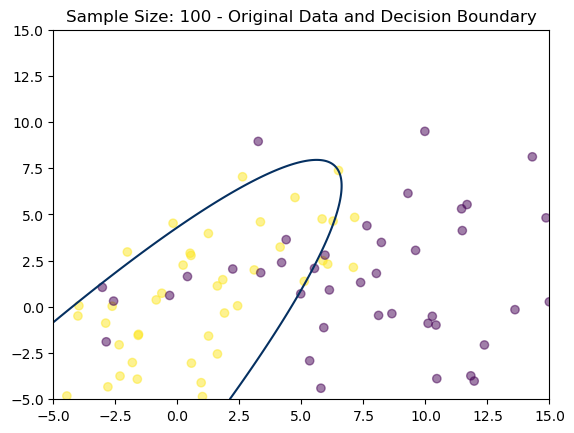

For disc model for sample size 200, Avg ||A_True - A*||/4: 0.1588, Avg ||B_True - B*||/2: 2.9679
For QDA for sample size 200, Avg ||A_True - A*||/4: 0.2140, Avg ||B_True - B*||/2: 4.4643


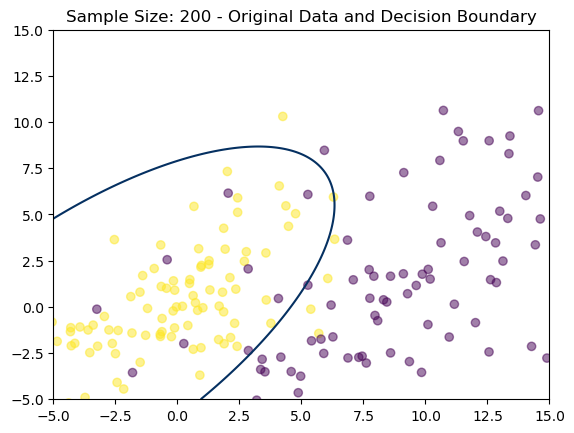

For disc model for sample size 500, Avg ||A_True - A*||/4: 0.1564, Avg ||B_True - B*||/2: 2.9950
For QDA for sample size 500, Avg ||A_True - A*||/4: 0.2140, Avg ||B_True - B*||/2: 4.4438


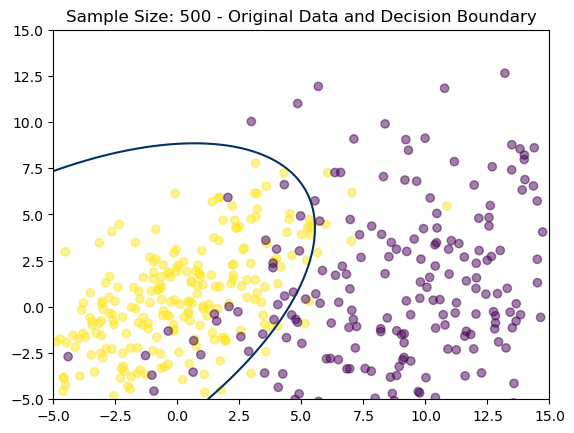

For disc model for sample size 1000, Avg ||A_True - A*||/4: 0.1569, Avg ||B_True - B*||/2: 3.0186
For QDA for sample size 1000, Avg ||A_True - A*||/4: 0.2142, Avg ||B_True - B*||/2: 4.4458


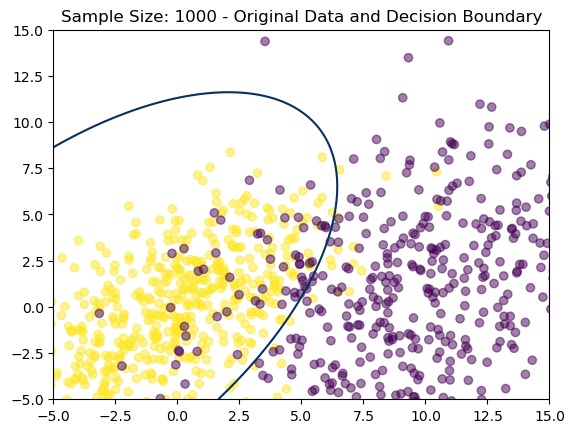

In [11]:
sample_sizes = [100, 200, 500, 1000]
results = []

for n in sample_sizes:
    errors_disc_train = []
    errors_disc_test = []
    errors_qda_train = []
    errors_qda_test = []
    norms_A = []
    norms_B = []
    norms_A_qda = []
    norms_B_qda = []
    for _ in range(10):
        x, y = generate_data(n)
        # Splitting the data into training and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        
        # Train the discriminative model on the training set
        A, B, C, error_history = train_discriminative_model(x_train, y_train)
        
        # Evaluate the discriminative model on both the training and test sets
        error_disc_train = evaluate_model(x_train, y_train, A, B, C)
        errors_disc_train.append(error_disc_train)
        error_disc_test = evaluate_model(x_test, y_test, A, B, C)
        errors_disc_test.append(error_disc_test)
        
        # Calculating norms and appending to lists
        norm_A = torch.norm(A_True - A) / 4
        norms_A.append(norm_A.item())
        norm_B = torch.norm(B_True.T - B.T) / 2  # B_True was transposed in its calculation
        norms_B.append(norm_B.item())
        
        # Train and evaluate the QDA model
        # Convert PyTorch tensors to NumPy arrays
        x_train_np, y_train_np = x_train.numpy(), y_train.numpy()
        x_test_np, y_test_np = x_test.numpy(), y_test.numpy()
        
        qda_model = QDA(store_covariance=True)
        qda_model.fit(x_train_np, y_train_np)
        
        # Evaluate mscl error on the training set
        y_pred_qda_train = qda_model.predict(x_train_np)
        error_qda_train = 1 - accuracy_score(y_train_np, y_pred_qda_train)
        errors_qda_train.append(error_qda_train)
        
        # Evaluate mscl error on the test set
        y_pred_qda_test = qda_model.predict(x_test_np)
        error_qda_test = 1 - accuracy_score(y_test_np, y_pred_qda_test)
        errors_qda_test.append(error_qda_test)
        # Approximating A* and B* for QDA
        cov_matrices_qda = [np.linalg.inv(cov) for cov in qda_model.covariance_]
        A_star_qda = np.mean(cov_matrices_qda, axis=0)
        norms_A_qda.append(torch.norm(A_True - torch.tensor(A_star_qda, dtype=torch.float32)) / 4)
        # For B*, using a heuristic approach based on class means
        means_qda = qda_model.means_
        delta_means_qda = np.linalg.inv(qda_model.covariance_) @ (means_qda[1] - means_qda[0])
        B_star_qda = torch.tensor(delta_means_qda, dtype=torch.float32).view(-1, 1)
        norms_B_qda.append(torch.norm(B_True.T - B_star_qda.T) / 2)
    # Calculating average errors
    avg_error_disc_train = np.mean(errors_disc_train)
    avg_error_disc_test = np.mean(errors_disc_test)
    avg_error_qda_train = np.mean(errors_qda_train)
    avg_error_qda_test = np.mean(errors_qda_test)
    avg_norm_A = np.mean(norms_A)
    avg_norm_B = np.mean(norms_B)
    avg_norm_A_qda = np.mean(norms_A_qda)
    avg_norm_B_qda = np.mean(norms_B_qda)
    print(f"For disc model for sample size {n}, Avg ||A_True - A*||/4: {avg_norm_A:.4f}, Avg ||B_True - B*||/2: {avg_norm_B:.4f}")
    print(f"For QDA for sample size {n}, Avg ||A_True - A*||/4: {avg_norm_A_qda:.4f}, Avg ||B_True - B*||/2: {avg_norm_B_qda:.4f}")

    results.append((n, avg_error_disc_train, avg_error_disc_test, avg_error_qda_train, avg_error_qda_test))    # Plotting inside the loop
    def model_predict(x):
        yhat = torch.sum((x @ A) * x, dim=1) + (x @ B + C).squeeze()
        return yhat

    xv, yv = np.meshgrid(np.linspace(-5, 15, 400), np.linspace(-5, 15, 400))
    grid_points = torch.tensor(np.c_[xv.ravel(), yv.ravel()], dtype=torch.float)

    model_outputs = model_predict(grid_points).detach().numpy()
    Z = model_outputs.reshape(xv.shape)

    plt.scatter(x.numpy()[:,0], x.numpy()[:,1], c=y.numpy(), cmap='viridis', alpha=0.5)
    plt.contour(xv, yv, Z, levels=[0], cmap="RdBu_r")
    plt.xlim(-5, 15)
    plt.ylim(-5, 15)
    plt.title(f"Sample Size: {n} - Original Data and Decision Boundary")
    plt.show()

## Results Summary
Results for each sample size by displaying the average misclassification error for both the discriminative model and QDA.

In [8]:
# Output results
for result in results:
    print(f"Sample Size: {result[0]}, Avg Misclassification Error (Discriminative): {result[1]:.4f}, Avg Misclassification Error (QDA): {result[2]:.4f}")

Sample Size: 100, Avg Misclassification Error (Discriminative): 0.0675, Avg Misclassification Error (QDA): 0.0650
Sample Size: 200, Avg Misclassification Error (Discriminative): 0.0662, Avg Misclassification Error (QDA): 0.0925
Sample Size: 500, Avg Misclassification Error (Discriminative): 0.0873, Avg Misclassification Error (QDA): 0.0850
Sample Size: 1000, Avg Misclassification Error (Discriminative): 0.0832, Avg Misclassification Error (QDA): 0.0830


## Misclassification Error Comparison Plot
Plot of the misclassification errors for both the discriminative model and QDA across different sample sizes.


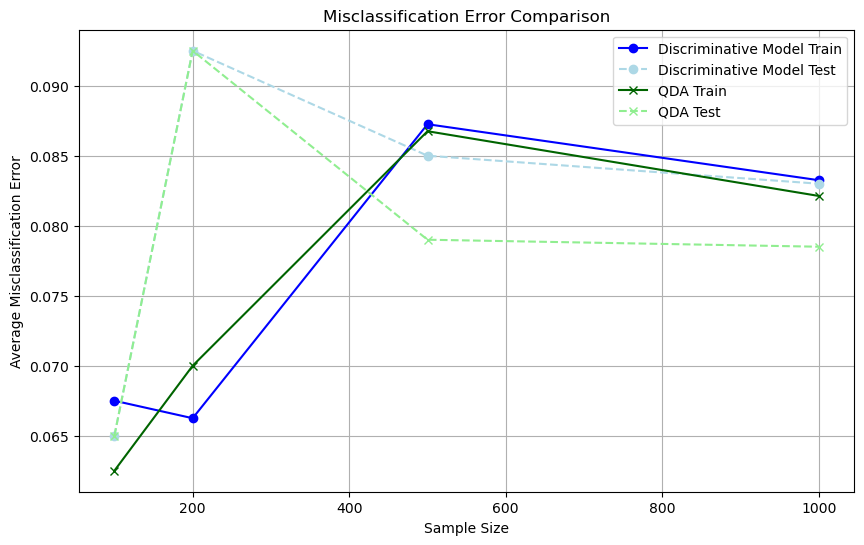

In [9]:
# Assuming 'results' is a list of tuples, where each tuple contains:
# (sample size, average misclassification error for Discriminative model, average misclassification error for QDA)

# Unpack the results into separate lists for plotting
sample_sizes, errors_disc_train, errors_disc_test, errors_qda_train, errors_qda_test = zip(*results)

# Create the plot for Discriminative Model Errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, errors_disc_train, label='Discriminative Model Train', marker='o', color='blue')
plt.plot(sample_sizes, errors_disc_test, label='Discriminative Model Test', marker='o', linestyle='--', color='lightblue')

# Create the plot for QDA Errors
plt.plot(sample_sizes, errors_qda_train, label='QDA Train', marker='x', color='darkgreen')
plt.plot(sample_sizes, errors_qda_test, label='QDA Test', marker='x', linestyle='--', color='lightgreen')

# Labeling the chart
plt.title('Misclassification Error Comparison')
plt.xlabel('Sample Size')
plt.ylabel('Average Misclassification Error')
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

## Misclassification Error vs. Epoch Number (n=1000)
Plot of misclassification error as a function of the epoch number for the discriminative model when the sample size is 1000.

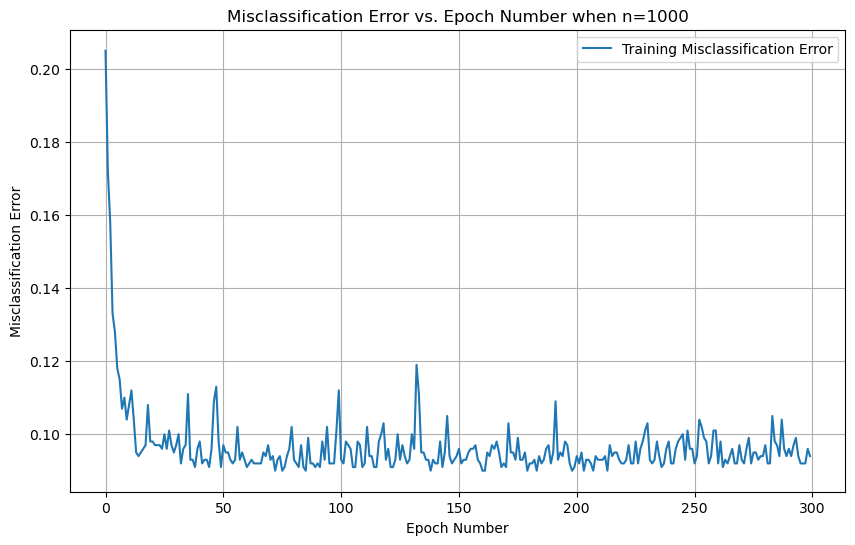

In [10]:
# Misclassification error vs epoch number (n=1000)
x, y = generate_data(1000)  # Example data generation
A, B, C, error_history = train_discriminative_model(x, y)
plt.figure(figsize=(10, 6))
plt.plot(error_history, label='Training Misclassification Error')
plt.title('Misclassification Error vs. Epoch Number when n=1000')
plt.xlabel('Epoch Number')
plt.ylabel('Misclassification Error')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
In this notebook, we explored and compared the performance of QDA with a discriminative model using Pytorch and generative model using Sklearn across various sample sizes. We evaluated their misclassification errors and visualized the decision boundaries. The results highlight the differences in performance between the two approaches, discriminative and  with implications for their use in different scenarios.